 # Automated Image Classification using Advanced Deep Learning Models
 The goal for this Lab is it to provide you understanding of the various deep learning models that we will be using in your project(s). In this Lab we will implement VGG Architecture over CUB200-2011 dataset:

 The CUB200-2011 dataset can be found on its [website](https://paperswithcode.com/dataset/cub-200-2011). We can either use the data zip file or import it using  [Kaggle](https://www.kaggle.com) and [kaggle-api](https://github.com/Kaggle/kaggle-api) which needs to be installed with `pip install kaggle`. I would prefer all of you do this using Google Colab. This will also help you with Last 3 Labs.

1. Total of 40,000 images are available in the dataset.  
2. Each image is of size 128x128 pixels (64x64).  
3. 10% of the total images (stratified) is our prototype dataset.  
    3.1 4000 images are used for prototyping.  
    3.2 3200 images are used for training and the rest are used for testing (800).  
4. Each image is annotated with a label. --> a classification  
5. Labs will require your own datasets with:  
    5.1 Lab 8 - Vgg16 model pre-trained weights on the 10% dataset.  
    5.2 Lab 9 - Yolo 6 model pre-trained weights on the 10% dataset.  
    5.3 Lab 10 - Inception model pre-trained weights on the 10% dataset.  
    5.4 ResNet 50 model pre-trained weights on the 10% dataset.  
6. Diagnostic plots for each model.  

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import PIL
import torchvision
import numpy as np
import pandas as pd
import tqdm
import cv2
import matplotlib.pyplot as plt
import os
import shutil

In [ ]:
# from zipfile import ZipFile
# file_name = ['/content/test - HSV.zip']
# for i in file_name:
#   with ZipFile(i, 'r') as z:
#     z.extractall()
#     print('Done')

 ## Data Preprocessing
 ### Downloading and extracting custom datasets
 ### Loading custom datasets
 ### Calculating the mean and std for normalization on custom datasets
 ### Loading transforms to augment and normalize our data

In [ ]:
train_path = '/content/train - HSV'
test_path = '/content/test - HSV'
classes = ['AnnualCrop','Forest','HerbaceousVegetation','Highway','Industrial','Pasture','PermanentCrop','Residential','River','SeaLake']

In [ ]:
from torchvision.transforms.transforms import CenterCrop
import cv2

class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return torchvision.transforms.functional.pad(image, padding, 0, 'constant')


means = [0.348,0.384,0.411]
stds = [0.094,0.067,0.0566]

transform = torchvision.transforms.Compose(
    [
      SquarePad(),
      torchvision.transforms.RandomHorizontalFlip(p = 0.5),
      torchvision.transforms.RandomVerticalFlip(p = 0.5),
      torchvision.transforms.Resize(224),
      #torchvision.transforms.CenterCrop(224),
      #torchvision.transforms.RandomResizedCrop(224, (0.8, 1.0)),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(
          mean=means,
          std=stds
          )
    ]
)

train = torchvision.datasets.ImageFolder(
    root = train_path,
    transform = transform
)


train_loader = torch.utils.data.DataLoader(
    train, 
    batch_size= 64,
    shuffle=True,
    num_workers=4
)

test = torchvision.datasets.ImageFolder(
    root = test_path,
    transform = transform
)


test_loader = torch.utils.data.DataLoader(
    test, 
    batch_size= 16,
    shuffle=True,
    num_workers=2
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


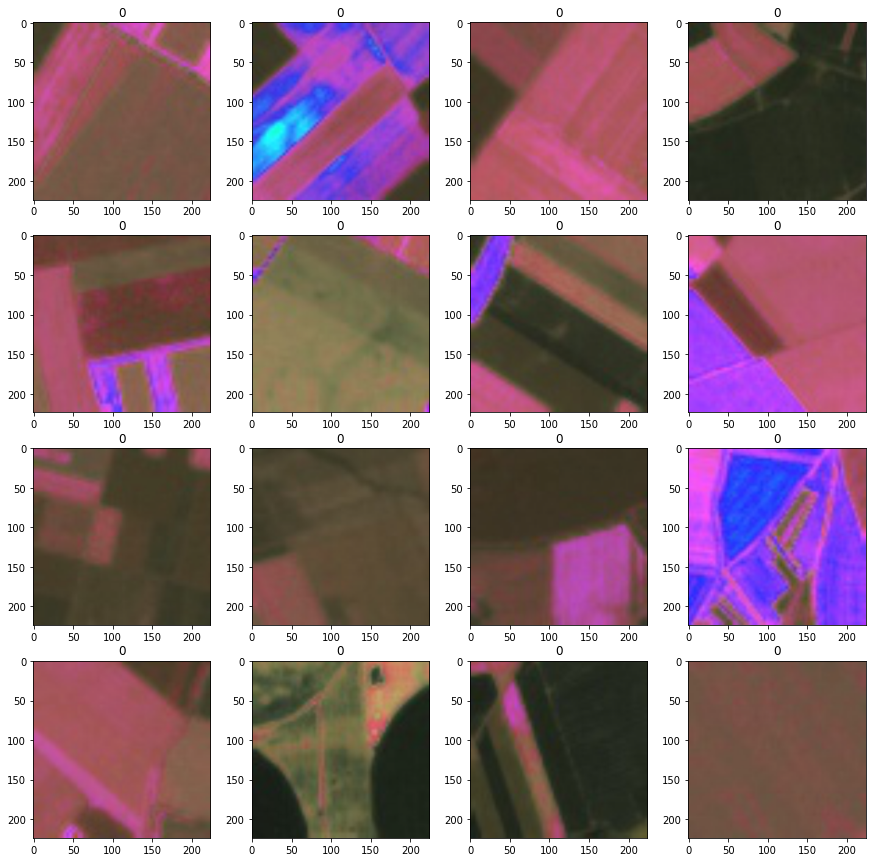

In [ ]:
fig, axes = plt.subplots(4,4,figsize= (15,15))

for i in range(16):

  img = train[i][0].numpy().transpose(1, 2, 0)
  img = np.clip((stds * img) + means, 0, 1)
  axes.flat[i].imshow(img)
  axes.flat[i].set_title(str(train[i][1]))

# Follow aspect ratio of either 1:1 or 1.68:1 (8.5, 4.75/5)
fig.savefig('train_image_transformations.jpg', dpi=300, bbox_inches='tight')  
fig.savefig('train_image_transformations.pdf', dpi=300, bbox_inches='tight')  
plt.show()

 ## Defining a Convolutional Neural Network
 ### Defining the VGG blocks
 ### Defining a CUB200-2011 VGG model

 ## Training a Convolutional Neural Network
 ### Loading a pre-trained model
 ### Loading pre-trained model parameters into a defined model
 ### Learning rate finder
 ### Discriminative fine-tuning
 ### One cycle learning rate scheduler

 ## Evaluating a Convolutional Neural Network
 ### Fine-tuning a pre-trained model to achieve ~80% top-1 accuracy and ~95% top-5 accuracy on a dataset with 200 classes and only 60 examples per class
 ### Viewing our model's mistakes
 ### Visualizing our data in lower dimensions with PCA and t-SNE
 ### Viewing the learned weights of our model

In [ ]:
from torchvision.transforms.transforms import CenterCrop


class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return torchvision.transforms.functional.pad(image, padding, 0, 'constant')


mean = [0.348,0.384,0.411]
std = [0.094,0.067,0.0566]

transform = torchvision.transforms.Compose(
    [
      SquarePad(),
      torchvision.transforms.RandomHorizontalFlip(p = 0.5),
      torchvision.transforms.RandomVerticalFlip(p = 0.5),
      torchvision.transforms.Resize(448),
      #torchvision.transforms.CenterCrop(224),
      #torchvision.transforms.RandomResizedCrop(224, (0.8, 1.0)),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(
          mean=mean,
          std=std
          )
    ]
)

train = torchvision.datasets.ImageFolder(
    root = train_path,
    transform = transform
)


train_loader = torch.utils.data.DataLoader(
    train, 
    batch_size= 32,
    shuffle=True,
    num_workers=2
)

test = torchvision.datasets.ImageFolder(
    root = test_path,
    transform = transform
)


test_loader = torch.utils.data.DataLoader(
    test, 
    batch_size= 16,
    shuffle=True,
    num_workers=2
)

In [ ]:
class VGGalter(nn.Module):

  def __init__(self):
    super().__init__()

    self.VGG =  torchvision.models.vgg16(pretrained= True)
    self.VGG.features[30] = nn.MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)

    self.FC4 = nn.Sequential(
        nn.ReLU(inplace = True),
        nn.Dropout(p = 0.5),
        nn.Linear(in_features=1000, out_features=10, bias=True)
    )


  def forward(self, x):

    x = self.VGG.features(x)
    x = self.VGG.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.VGG.classifier(x)
    
    x = self.FC4(x)

    return x


ComplexVGG = VGGalter()


cuda = torch.cuda.is_available()


if cuda:
 ComplexVGG.cuda()

print(ComplexVGG)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGGalter(
  (VGG): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): M

In [ ]:
optimizer = optim.SGD(params = ComplexVGG.parameters(),   lr= 1e-3, momentum= 0.9 )
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = nn.CrossEntropyLoss()

In [ ]:
EPOCHS = 50

train_loss = [np.nan]
train_accuracy = [np.nan]
test_accuracy = [np.nan]
test_loss = [np.nan]
best_test_acc = -np.inf
best_snapshot_path = None

ComplexVGG.train()


pbar = tqdm.tqdm(total = EPOCHS, position= 0, leave = True)
pbar.set_description("EPOCH 1: Training Loss: NA, ")


for epoch in range(EPOCHS):
  
  total, correct, running_loss = 0, 0, 0

  for batch_idx, (data,target) in enumerate(train_loader):

    ComplexVGG.train()

    if cuda:
      data, target = data.cuda(), target.cuda()

    optimizer.zero_grad()

    out = ComplexVGG(data)

    loss = criterion(out, target)
    loss.backward()
    optimizer.step()


    current_loss = loss.cpu().data.item()
    running_loss += current_loss


    _, predicted = out.max(1)
    total += target.size(0)
    correct += predicted.eq(target).sum().cpu().item()
          
    #scheduler.step()

    pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}%\t Test Loss: {test_loss[-1]:.3f}\t Test Acc: {test_accuracy[-1]:.3f}%\t")


  test_total, test_correct, test_running_loss = 0, 0, 0
  ComplexVGG.eval()


  with torch.no_grad():


    for batch_idx, (data,target) in enumerate(test_loader):

      if cuda:
        data, target = data.cuda(), target.cuda()

      out = ComplexVGG(data)

      loss = criterion(out, target)

      test_running_loss += loss.cpu().data.item()

      _, predicted = out.max(1)
      test_total += target.size(0)
      test_correct += predicted.eq(target).sum().cpu().item()


    test_accu=100.*test_correct/test_total
    LTest = test_running_loss/len(test_loader)

    if test_accu > best_test_acc:
      best_test_acc = test_accu

      if best_snapshot_path is not None:
        os.remove(best_snapshot_path)
      
      best_snapshot_path = os.path.join(f'VGGCustom_ep={epoch + 1}_acc={best_test_acc:.2f}.pt')
      torch.save(ComplexVGG.state_dict(), best_snapshot_path)

  
  LTrain=running_loss/len(train_loader)
  accu=100.*correct/total
    
  train_accuracy.append(accu)
  test_accuracy.append(test_accu)
  train_loss.append(LTrain)
  test_loss.append(LTest)

  pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}%\t Test Loss: {test_loss[-1]:.3f}\t Test Acc: {test_accuracy[-1]:.3f}%\t")

  pbar.update()

del train_accuracy[0]
del test_accuracy[0]
del train_loss[0]
del test_loss[0]

In [ ]:
ComplexVGG.load_state_dict(torch.load(best_snapshot_path))

In [ ]:
def save_model(m, p):
    torch.save(m.state_dict(), p)
    
def load_model(m, p):
    m.load_state_dict(torch.load(p))
p = "HSV_VGG_model1_tmp.pth"
# save_model(ComplexVGG, str(p))
load_model(ComplexVGG, str(p))

In [ ]:
# plt.savefig("Loss vs Epochs.jpg", dpi = 300, bbox_inches = 'tight')
# plt.savefig("Loss vs Epochs.pdf", dpi = 300, bbox_inches = 'tight')

myrcparams = RcParams({'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#EAEAF2',
          'axes.grid': True,
          'axes.labelcolor': '.15',
          'axes.linewidth': 0.0,
          'figure.facecolor': 'white',
          'font.family': ['serif'],
          'grid.color': 'white',
          'grid.linestyle': '--',
          'image.cmap': 'Greys',
          'legend.frameon': False,
          'legend.numpoints': 1,
          'legend.scatterpoints': 1,
          'lines.solid_capstyle': 'round',
          'text.color': '.15',
          'xtick.color': '.15',
          'xtick.direction': 'out',
          'xtick.major.size': 0.0,
          'xtick.minor.size': 0.0,
          'ytick.color': '.15',
          'ytick.direction': 'out',
          'ytick.major.size': 0.0,
          'ytick.minor.size': 0.0})

plt.style.library['seaborn-whitegrid']
RcParams.update(myrcparams)

fig, ax = plt.subplots(figsize =(15,11))

x = np.arange(1,len(train_loss)+1)

ax.plot(x, train_loss, '-o', label = "Train Loss")
ax.plot(x, test_loss, '-o', label = "Test Loss")

ax.set_xlabel("Epochs", fontsize = 20)
ax.set_ylabel("Loss", fontsize = 20)
ax.set_title('HSV - VGG16 Epochs vs. Loss',fontsize = 25)

ax.tick_params(
    axis = 'both',
    labelsize = 16
)
ax.legend(fontsize = 20)
plt.savefig("HSV_VGG16_Loss_vs_Epochs.jpg", dpi = 300, bbox_inches = 'tight')
plt.savefig("HSV_VGG16_Loss_vs_Epochs.pdf", dpi = 300, bbox_inches = 'tight')
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize =(15,11))

x = np.arange(1,len(train_accuracy)+1)

ax.plot(x, train_accuracy, '-o', label = "Train Accuracy")
ax.plot(x, test_accuracy, '-o', label = "Test Accuracy")

ax.set_xlabel("Epochs", fontsize = 20)
ax.set_ylabel("Accuracy", fontsize = 20)
ax.set_title('HSV - VGG16 Epochs vs. Accuracy',fontsize = 25)

ax.tick_params(
    axis = 'both',
    labelsize = 16
)
ax.legend(fontsize = 20)
plt.savefig("HSV_VGG16_Epochs_vs_Accuracy.jpg", dpi = 300, bbox_inches = 'tight')
plt.savefig("HSV_VGG16_Epochs_vs_Accuracy.pdf", dpi = 300, bbox_inches = 'tight')
plt.show()


In [ ]:
correct = 0
total = 0

ComplexVGG.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        if cuda:
          data, target = data.cuda(), target.cuda()
        
        out = ComplexVGG(data)


        for _,i in enumerate(out):
            
            if target[_].cpu().item() in torch.argsort(i)[-5:].cpu().numpy():
                correct += 1
            total += 1

correct/total

In [ ]:
idx_to_class = inv_map = {v: k for k, v in test.class_to_idx.items()}

correct = []
pred = []

ComplexVGG.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        if cuda:
          data, target = data.cuda(), target.cuda()
        
        out = ComplexVGG(data)


        for _,i in enumerate(out):

            pred.append(torch.argmax(i).cpu().item())
            correct.append(target[_].cpu().item())

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def accuracy(output, target, top=(1,)):
    """Computes the precision@k for the specified values of k"""
    #with torch.no_grad():
    maxk = max(top)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in top:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [ ]:
def calc_accuracy(model, dataloader):
    model.eval()
    model.cuda()    
    
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    for idx, (inputs, labels) in enumerate(dataloader):
        
        inputs, labels = inputs.cuda().float(), labels.cuda().long()
        # obtain the outputs from the model
        outputs = model.forward(inputs)
        #outputs = torch.stack(list(outputs), dim = 0)
        prec1, prec5 = accuracy(outputs, labels, top=(1, 5))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))
        
    return top1 ,top5

In [ ]:
top1,top5=calc_accuracy(ComplexVGG, test_loader)

In [ ]:
top1.avg

tensor(91.1111, device='cuda:0')

In [ ]:
top5.avg

tensor(99.8148, device='cuda:0')

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, plot_confusion_matrix, ConfusionMatrixDisplay
classes = ['AnnualCrop','Forest','HerbaceousVegetation','Highway','Industrial','Pasture','PermanentCrop','Residential','River','SeaLake']

labels = np.arange(0,10)
label_dict = dict(zip(labels,classes))
conf = confusion_matrix(y_pred= pred, y_true = correct)
p = ConfusionMatrixDisplay(conf,display_labels = classes)
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Confusion Matrix - VGG16')

p.plot(ax=ax,xticks_rotation=45, cmap = "Blues")
plt.savefig('HSV_VGG16_Confusion_Matrix.jpg',dpi = 300, bbox_inches = 'tight')
plt.savefig('HSV_VGG16_Confusion_Matrix.pdf',dpi = 300, bbox_inches = 'tight')

x = {'HSV_VGG16_Train_Acc':train_accuracy,'HSV_VGG16_Test_Acc':test_accuracy, 'HSV_VGG16_Train_Loss':train_loss,'HSV_VGG16_Test_Loss':test_loss,'VGG16_Top_1':0,'VGG16_Top_5':0}
import pandas as pd
DF = pd.DataFrame.from_dict(x)
DF.to_csv('Accuracy_VGG16.csv')

download_files = ['HSV_VGG16_Confusion_Matrix.jpg','HSV_VGG16_Confusion_Matrix.pdf',"HSV_VGG16_Loss_vs_Epochs.jpg","HSV_VGG16_Loss_vs_Epochs.pdf","HSV_VGG16_Epochs_vs_Accuracy.jpg","HSV_VGG16_Epochs_vs_Accuracy.pdf",'Accuracy_VGG16.csv']
from google.colab import files
for i in download_files:
  files.download(i)